In [37]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gamma, poisson

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.gam.api import GLMGam, BSplines

from statsmodels.tools.eval_measures import rmse, mse

from zmq.constants import NULL

import warnings
warnings.filterwarnings('ignore')

In [38]:
# gss16 = pd.read_csv('data/preprocessing/X_fill.csv')
X = pd.read_csv("data/preprocessing/X.csv")
y = pd.read_csv("data/preprocessing/y.csv")
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dat_train = pd.concat([X_train, y_train], axis=1)
dat_test = pd.concat([X_test, y_test], axis=1)


Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'advfront_Agree', 'advfront_Disagree', 'advfront_Dont_know',
       'advfront_Strongly_agree', 'advfront_Strongly_disagree', 'snapchat_No',
       'snapchat_Yes', 'instagrm_No', 'instagrm_Yes', 'wrkstat_Keeping_house',
       'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School',
       'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off',
       'wrkstat_Working_fulltime', 'wrkstat_Working_parttime'],
      dtype='object')


# 3. Mô hình GAM

Mô hình hồi quy cộng tính tổng quát (GAM - Generalized Additive Models) là trường hợp tổng quát hơn của GLM. GAM cố gắng mô hình hóa cả tác động của các biến độc lập mà có quan hệ phi tuyến với biến phụ thuộc.

Công thức tổng quát của GAM:

$g(\mu) =  \sum_{k} \alpha_k X_k + \sum_{j} s_j(Z_j)$

Trong đó:

- $\mu=E(Y)$ với $Y$ là biến phụ thuộc có phân phối họ mũ
- $X_k$ là các biến độc lập có tác động tuyến tính đến biến phụ thuộc, các hệ số $\alpha_k$ chưa biết.
- $Z_j$ là các biến độc lập có tác động phi tuyến đến biến phụ thuộc, $s_j(.)$ là hàm trơn (spline)
- $g(.)$ là link function

GAM được ước lượng bằng phương pháp hợp lý cực đại có phạt, trong đó các hàm trơn được ước lượng qua các spline và nút.

Đầu tiên ta thử fit mô hình với tất cả các biến mà GLM đã chọn ở trên. Các tham số của GAM cần chọn:
- degree: bậc của hàm trong 1 đoạn spline
- df (degree of freedom): số bậc tự do của spline
- alpha: hệ số phạt


In [39]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=8, degree=3)
alpha = 10
formula = """
    email_time_center ~ C(Q('harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)')) +
       C(harass5_No) + C(harass5_Yes)  + C(polviews_Conservative) +
       C(polviews_Extremely_liberal) + C(polviews_Extrmly_conservative) +
       C(polviews_Liberal) + (polviews_Moderate) +
       C(polviews_Slghtly_conservative) + C(polviews_Slightly_liberal) +
       C(advfront_Agree) + C(advfront_Disagree) +
       C(advfront_Dont_know) + C(advfront_Strongly_agree) +
       C(advfront_Strongly_disagree) + C(wrkstat_Keeping_house) +
       C(wrkstat_Other) +
       C(wrkstat_Retired) + C(wrkstat_School) + C(wrkstat_Temp_not_working) +
       C(Q('wrkstat_Unempl,_laid_off')) + C(wrkstat_Working_fulltime) +
       C(wrkstat_Working_parttime)
"""

gam_bs = GLMGam.from_formula(formula = formula,
                             data=dat_train, smoother=bs, alpha=alpha,
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
fitted_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      email_time_center   No. Observations:                 1319
Model:                         GLMGam   Df Residuals:                      NaN
Model Family:                   Gamma   Df Model:                          NaN
Link Function:                    Log   Scale:                             nan
Method:                         PIRLS   Log-Likelihood:                    nan
Date:                Tue, 15 Aug 2023   Deviance:                       14089.
Time:                        14:18:15   Pearson chi2:                 4.09e+03
No. Iterations:                    22   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       -6.2276        nan        nan        nan         nan         nan
C(Q('harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)'))[T.1]     1.1708        nan        nan        nan         nan         nan
C(harass5_No)[T.1]                                                               1.9447        nan        nan        nan         nan         nan
C(harass5_Yes)[T.1]                                                              2.1157        nan        nan        nan         nan         nan
C(polviews_Conservative)[T.1]                                                   -0.4790        nan        nan        nan         nan         nan
C(polviews_Extremely_liberal)[T.1]                                              -0.6026        nan        nan        nan         nan         nan
C(polviews_Extrmly_conservative)[T.1]                                           -1.0117        nan        nan        nan         nan         nan
C(polviews_Liberal)[T.1]                                                        -0.5859        nan        nan        nan         nan         nan
C(polviews_Slghtly_conservative)[T.1]                                           -0.5416        nan        nan        nan         nan         nan
C(polviews_Slightly_liberal)[T.1]                                               -0.4147        nan        nan        nan         nan         nan
C(advfront_Agree)[T.1]                                                           2.0139        nan        nan        nan         nan         nan
C(advfront_Disagree)[T.1]                                                        2.2738        nan        nan        nan         nan         nan
C(advfront_Dont_know)[T.1]                                                       1.4927        nan        nan        nan         nan         nan
C(advfront_Strongly_agree)[T.1]                                                  2.0828        nan        nan        nan         nan         nan
C(advfront_Strongly_disagree)[T.1]                                               2.6295        nan        nan        nan         nan         nan
C(wrkstat_Keeping_house)[T.1]                                                   -0.2032        nan        nan        nan         nan         nan
C(wrkstat_Other)[T.1]                                                            0.5212        nan        nan        nan         nan         nan
C(wrkstat_Retired)[T.1]                                                         -0.0503        nan        nan        nan         nan         nan
C(wrkstat_School)[T.1]                

Tiếp theo ta fit mô hình với df lớn hơn để tăng tính linh động của spline

In [40]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=90, degree=3)
alpha = 10
formula = """
    email_time_center ~ C(Q('harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)')) +
       C(harass5_No) + C(harass5_Yes)  + C(polviews_Conservative) +
       C(polviews_Extremely_liberal) + C(polviews_Extrmly_conservative) +
       C(polviews_Liberal) + (polviews_Moderate) +
       C(polviews_Slghtly_conservative) + C(polviews_Slightly_liberal) +
       C(advfront_Agree) + C(advfront_Disagree) +
       C(advfront_Dont_know) + C(advfront_Strongly_agree) +
       C(advfront_Strongly_disagree) + C(wrkstat_Keeping_house) +
       C(wrkstat_Other) +
       C(wrkstat_Retired) + C(wrkstat_School) + C(wrkstat_Temp_not_working) +
       C(Q('wrkstat_Unempl,_laid_off')) + C(wrkstat_Working_fulltime) +
       C(wrkstat_Working_parttime)
"""

gam_bs = GLMGam.from_formula(formula = formula,
                             data=dat_train, smoother=bs, alpha=alpha,
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
# fitted_gam.summary()
print('Pseudo R-squared: ', fitted_gam.pseudo_rsquared())

Pseudo R-squared:  nan


Cố định các tham số degree, df, dùng grid search để chọn alpha tối ưu thông qua tính toán AIC, BIC.

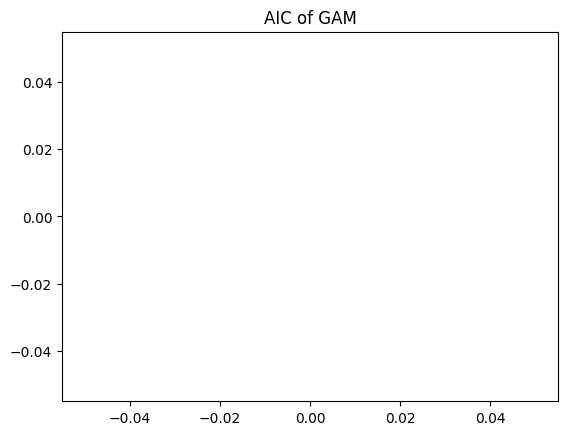

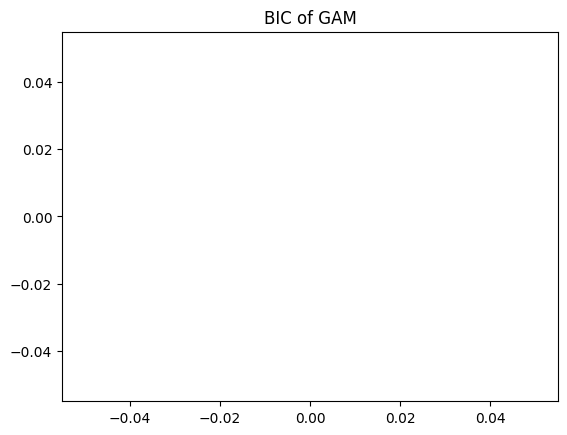

In [41]:
aic_gam = []
bic_gam = []

al = [0.001, 0.01, 0.1, 1]
al = range(1, 100, 10)
# al = range(20)

for i in range(len(al)):
    x_spline = dat_train["educ_center"]
    bs = BSplines(x_spline, df=200, degree=3)
    
    formula = """
    email_time_center ~ C(Q('harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)')) +
       C(harass5_No) + C(harass5_Yes)  + C(polviews_Conservative) +
       C(polviews_Extremely_liberal) + C(polviews_Extrmly_conservative) +
       C(polviews_Liberal) + (polviews_Moderate) +
       C(polviews_Slghtly_conservative) + C(polviews_Slightly_liberal) +
       C(advfront_Agree) + C(advfront_Disagree) +
       C(advfront_Dont_know) + C(advfront_Strongly_agree) +
       C(advfront_Strongly_disagree) + C(wrkstat_Keeping_house) +
       C(wrkstat_Other) +
       C(wrkstat_Retired) + C(wrkstat_School) + C(wrkstat_Temp_not_working) +
       C(Q('wrkstat_Unempl,_laid_off')) + C(wrkstat_Working_fulltime) +
       C(wrkstat_Working_parttime)
    """
    gam_bs = GLMGam.from_formula(formula = formula,
                                 data=dat_train, smoother=bs, alpha=al[i],
                                 family=sm.families.Gamma(link=sm.families.links.Log()))

    fitted_gam = gam_bs.fit()

    aic_gam.append(fitted_gam.aic)
    bic_gam.append(fitted_gam.bic)

plt.plot(range(len(aic_gam)), aic_gam)
plt.title("AIC of GAM")
plt.show()

plt.plot(range(len(bic_gam)), bic_gam)
plt.title("BIC of GAM")
plt.show()

Như vậy, trường hợp này, alpha tối ưu bằng 100. Ta fit lại mô hình GAM để xem kết quả

In [42]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=200, degree=3)

formula = """
    email_time_center ~ C(Q('harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)')) +
       C(harass5_No) + C(harass5_Yes)  + C(polviews_Conservative) +
       C(polviews_Extremely_liberal) + C(polviews_Extrmly_conservative) +
       C(polviews_Liberal) + (polviews_Moderate) +
       C(polviews_Slghtly_conservative) + C(polviews_Slightly_liberal) +
       C(advfront_Agree) + C(advfront_Disagree) +
       C(advfront_Dont_know) + C(advfront_Strongly_agree) +
       C(advfront_Strongly_disagree) + C(wrkstat_Keeping_house) +
       C(wrkstat_Other) +
       C(wrkstat_Retired) + C(wrkstat_School) + C(wrkstat_Temp_not_working) +
       C(Q('wrkstat_Unempl,_laid_off')) + C(wrkstat_Working_fulltime) +
       C(wrkstat_Working_parttime)
"""

# gam_bs = GLMGam.from_formula(formula = 'emailmintotal ~ wrkstat + polviews + advfront + harass5', \
gam_bs = GLMGam.from_formula(formula = formula,
                                data=dat_train, smoother=bs, alpha=100,
                                family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
# fitted_gam.summary()
fitted_gam.pseudo_rsquared()


nan

Có thể thấy, so với GLM thì trong trường hợp này GAM cho kết quả $R^2$ cải thiện gần 8%.

# 5. Kết luận

Như vậy, so sánh giữa GLM và GAM cho bài toán này thì GAM có vẻ cho kết quả tốt hơn 1 chút. Điều này hợp với lý thuyết vì GAM tổng quát hơn nên nó fit được dữ liệu phức tạp hơn.

Tuy nhiên, cả 2 mô hình đều cho $R^2$ khá thấp. Vì sao $R^2$ thấp:
- Đây là bài toán dự đoán thời gian dùng email, nhưng trong dữ liệu chỉ có 1 biến giải thích duy nhất là biến lượng (educ), còn lại đều là biến categorical. Biến educ này cũng không có quan hệ tuyến tính hay quan hệ đơn giản với biến phụ thuộc (thời gian dùng email).
- Dữ liệu phân tán. Nếu dùng ngưỡng xác định outlier thông thường với Cook's distance là 4/n (n là số dòng của tập dữ liệu train) thì có tới 110/1318 mẫu được xác định là outlier (chiếm 8,4%). Chúng em đã thử loại bỏ toàn bộ 111 mẫu này khỏi tập dữ liệu và train lại mô hình thì $R^2$ đạt cỡ trên 36% (khoảng gấp 3 lần $R^2$ nếu dùng cùng mô hình trên tập dữ liệu chưa loại outlier). Tuy nhiên, để đảm bảo tập dữ liệu gốc, chúng em chỉ loại 10 điểm có Cook's distance lớn nhất thì thấy $R^2$ đã tăng gần 80%.
- Tập dữ liệu tuy không nhỏ nhưng nhiều dòng chứa giá trị NaN.
- Liên quan tới thời gian dùng email của 1 người thì có thể có những thông tin quan trọng hơn mà tập dữ liệu này không cung cấp. Ví dụ cùng là làm việc fulltime nhưng với từng nghề nghiệp cụ thể, như công nhân so với nhân viên văn phòng sẽ có mức dùng email rất khác nhau...